In [ ]:
import sys
path = '/Users/xiehao/Desktop/workspace/X2AI/sugar_ai/'
if path not in sys.path:
    sys.path.append(path)

from IPython.display import Markdown
import pandas as pd
from DataBuilder.hisugar.crawler import HigSugarCrawler
from base import DBFile, DBSQL
from AIBots.SentimentalBot.robot import SentimentalBot

# 设置参数
table = "aisugar_hisugar"
start_date = "2025-01-01"
end_date = "2025-12-31"

# 爬取数据
# HigSugarCrawler(
#     start_date=start_date,
#     end_date=end_date,
#     db=DBSQL()
# ).crawl()

# 同步数据: 从 SQL数据库 同步到 文件数据库
# df = DBSQL().read_data(table=table, start_date=start_date, end_date=end_date)
# DBFile().save_data(df=df, table=table)

# 同步数据：从BigQuant 同步到 文件数据库
# df = pd.read_parquet("data.parquet", engine='pyarrow')
# DBFile().save_data(df, "aisugar_hisugar")

# AI 研究
# bot = SentimentalBot(db=DBFile(), start_date=start_date, end_date=end_date)
# bot.analyzing()

In [ ]:
import sys
path = '/Users/xiehao/Desktop/workspace/X2AI/sugar_ai/'
if path not in sys.path:
    sys.path.append(path)

from IPython.display import Markdown
import pandas as pd
from datetime import timedelta
from base import DBFile
from AIBots.SentimentalBot.robot import SentimentalBot

# 设置参数
table = "aisugar_hisugar"
today = pd.to_datetime("2023-03-29")
start_date = (today-timedelta(days=7)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")

start_date = "2023-01-01"
end_date = "2023-05-01"

# AI 研究
bot = SentimentalBot(db=DBFile(), start_date=start_date, end_date=end_date)

data = bot.get_articles()
assistant_reports = bot.assistant(data)

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(assistant_reports)
df["rating"] = df["rating"].replace({"看多": 1, "中性": 0, "看空": -1})
df = df[df["rating"]!=""]
df["rating"] = df["rating"].astype(int)
# 按日期和rating分组计数
rating_counts = df.groupby(['date', 'rating']).size().unstack(fill_value=0)

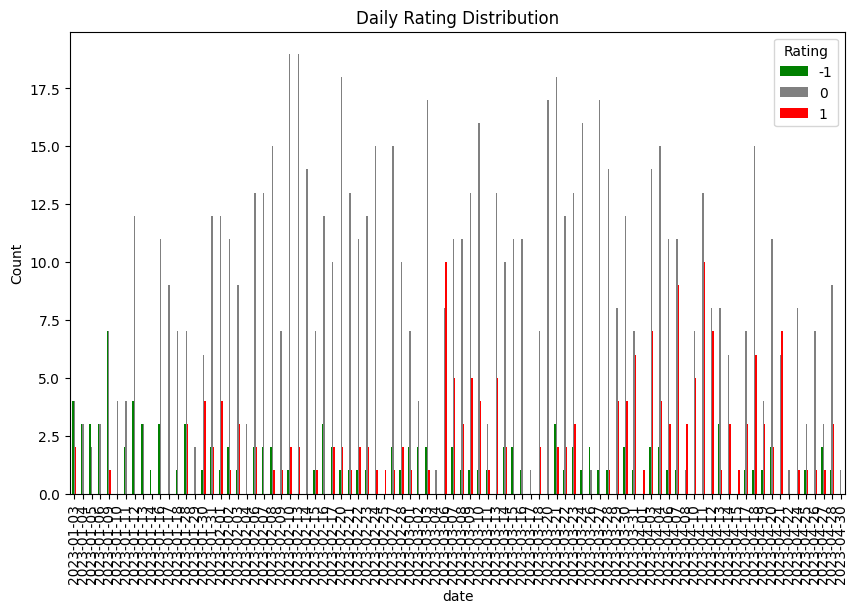

In [3]:
# 按日期和rating分组计数
rating_counts = df.groupby(['date', 'rating']).size().unstack(fill_value=0)

color_map = {-1: 'green', 0: 'gray', 1: 'red'}
colors = [color_map[col] for col in rating_counts.columns]

ax = rating_counts.plot(kind='bar', stacked=False, color=colors, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_title('Daily Rating Distribution')
ax.legend(title='Rating')

# # 在每个柱子上标注数值
# for i, date in enumerate(rating_counts.index):
#     for j, rating in enumerate(rating_counts.columns):
#         value = rating_counts.loc[date, rating]
#         ax.text(i + (j-1)*0.25, value + 0.1, str(value), ha='center', va='bottom', fontsize=10, color=colors[j])

plt.show()

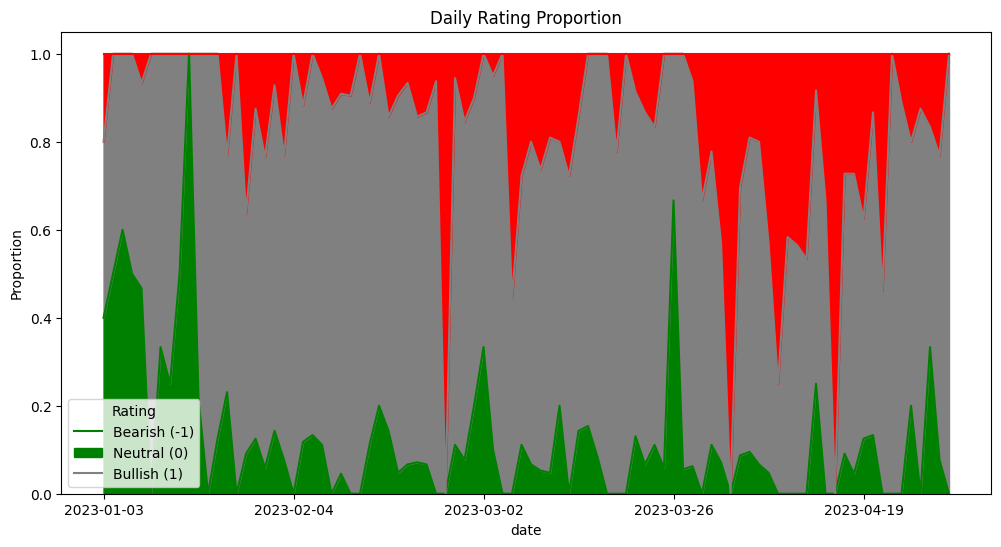

In [4]:
# 计算每天各rating的占比
rating_proportion = rating_counts.div(rating_counts.sum(axis=1), axis=0)

# 按照-1, 0, 1的顺序排列
order = [-1, 0, 1]
rating_proportion = rating_proportion[order]

# 绘制堆叠面积图
color_map = {-1: 'green', 0: 'gray', 1: 'red'}
ax = rating_proportion.plot(kind='area', stacked=True, color=[color_map[i] for i in order], figsize=(12, 6))
ax.set_ylabel('Proportion')
ax.set_title('Daily Rating Proportion')
ax.legend(title='Rating', labels=['Bearish (-1)', 'Neutral (0)', 'Bullish (1)'])
plt.show()

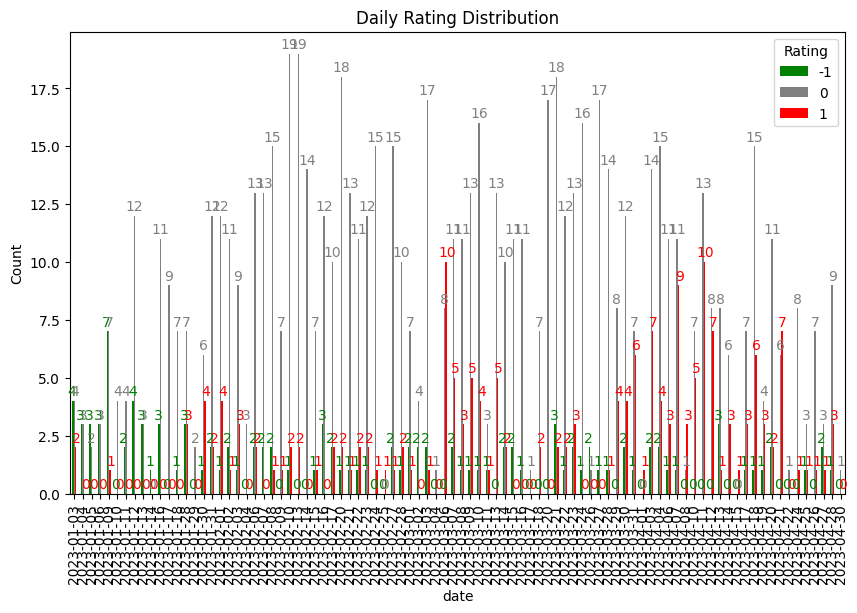

In [5]:
color_map = {-1: 'green', 0: 'gray', 1: 'red'}
colors = [color_map[col] for col in rating_counts.columns]

ax = rating_counts.plot(kind='bar', stacked=False, color=colors, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_title('Daily Rating Distribution')
ax.legend(title='Rating')

# 在每个柱子上标注数值
for i, date in enumerate(rating_counts.index):
    for j, rating in enumerate(rating_counts.columns):
        value = rating_counts.loc[date, rating]
        ax.text(i + (j-1)*0.25, value + 0.1, str(value), ha='center', va='bottom', fontsize=10, color=colors[j])

plt.show()

In [6]:
import os
from typing import List, Optional, Dict, Any
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import json


class FileDB:
    """通用文件数据库基类，处理基于目录结构的文件存储"""
    
    DEFAULT_PARTITION_FIELD = "__DEFAULT_PARTITION_FIELD__"
    
    def __init__(self, base_path: Optional[str] = None):
        """
        初始化文件数据库
        
        :param base_path: 数据库根目录路径，如果为None则使用项目目录下的DataBase
        """
        if base_path is None:
            self.base_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), "DataBase")
        else:
            self.base_path = base_path
            
        os.makedirs(self.base_path, exist_ok=True)

    def save_data(
        self,
        data: pd.DataFrame,
        table_name: str,
        keys: List[str],
        partition_cols: Optional[List[str]] = None,
        compression: str = 'snappy'
    ) -> None:
        """
        将DataFrame保存为Parquet格式，支持分区存储和去重
        
        Args:
            data: 要存储的DataFrame
            table_name: 表名，将作为子目录名称
            keys: 唯一键列名列表，用于去重
            partition_cols: 分区列名列表，如果为None则不分区
            compression: 压缩算法，默认为'snappy'
        """
        # 创建表目录
        table_path = os.path.join(self.base_path, table_name)
        os.makedirs(table_path, exist_ok=True)
        
        # 去重
        if keys:
            data = data.drop_duplicates(subset=keys, keep="last")
        
        # 转换为Arrow Table
        arrow_table = pa.Table.from_pandas(data)
        
        # 保存数据
        if partition_cols:
            # 分区存储
            ds.write_dataset(
                arrow_table,
                table_path,
                format="parquet",
                partitioning=partition_cols,
                existing_data_behavior="overwrite_or_ignore",
                basename_template="part-{i}.parquet",
                compression=compression
            )
        else:
            # 单文件存储
            pq.write_table(
                arrow_table,
                os.path.join(table_path, "data.parquet"),
                compression=compression
            )
        
        # 保存元数据
        self._save_metadata(
            table_name=table_name,
            keys=keys,
            partition_cols=partition_cols,
            schema=arrow_table.schema
        )

    def read_data(
        self,
        table_name: str,
        filters: Optional[List[tuple]] = None,
        columns: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """
        从Parquet文件中读取数据
        
        Args:
            table_name: 表名
            filters: 过滤条件，例如[('date', '>=', '2023-01-01')]
            columns: 要读取的列名列表
            
        Returns:
            读取的DataFrame
        """
        table_path = os.path.join(self.base_path, table_name)
        
        if not os.path.exists(table_path):
            raise FileNotFoundError(f"Table {table_name} not found")
        
        # 读取元数据
        metadata = self._load_metadata(table_name)
        
        # 检查是否是分区表
        if metadata['partition_cols']:
            dataset = ds.dataset(table_path, format="parquet", partitioning="hive")
            scanner = dataset.scanner(filter=filters, columns=columns)
            table = scanner.to_table()
        else:
            table = pq.read_table(
                os.path.join(table_path, "data.parquet"),
                filters=filters,
                columns=columns
            )
        
        return table.to_pandas()

    def _save_metadata(
        self,
        table_name: str,
        keys: List[str],
        partition_cols: Optional[List[str]],
        schema: pa.Schema
    ) -> None:
        """保存表的元数据"""
        metadata = {
            "table_name": table_name,
            "keys": keys,
            "partition_cols": partition_cols,
            "schema": {
                "names": schema.names,
                "types": [str(field.type) for field in schema]
            },
            "created_at": pd.Timestamp.now().isoformat()
        }
        
        metadata_path = os.path.join(self.base_path, table_name, "_metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

    def _load_metadata(self, table_name: str) -> Dict[str, Any]:
        """加载表的元数据"""
        metadata_path = os.path.join(self.base_path, table_name, "_metadata.json")
        
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(f"Metadata for table {table_name} not found")
        
        with open(metadata_path, 'r') as f:
            return json.load(f)

    def list_tables(self) -> List[str]:
        """列出所有表名"""
        return [d for d in os.listdir(self.base_path) 
                if os.path.isdir(os.path.join(self.base_path, d)) and not d.startswith('_')]

    def table_exists(self, table_name: str) -> bool:
        """检查表是否存在"""
        return os.path.exists(os.path.join(self.base_path, table_name))

NameError: name '__file__' is not defined